# SCL Elections challenge

SCL has won a contract from a consumer goods brand manager, ACME Industries, to model its existing consumer records management system and try to propose high-value targets to maximize the effectiveness of their targeted marketing.

We have purchased a large record of consumer data for the 2,000,000 customers provided by ACME, and an additional 500,000 records for potential future targets. These include various demographic details and also a selection of proprietary Consumer Expenditure models for each consumer.

1) The 2,000,000 records are provided in the file “modellingProjectTraining.txt”. Using any method you deem suitable, build a predictive model that takes the various datapoints provided for each consumer and predicts the ‘Consumer Value’ assigned by ACME Industries, which is a measure of the value of the customer to the company.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

# Import the random forest package
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import cross_validation
from sklearn.cross_validation import KFold
import sklearn.metrics as metric
from scipy.stats import chisquare

# Functions

In [75]:
#Convert Gender feature into numerical value
def seq(x):
    if (x == 'M') or (x == 1):
        x = 1
    elif (x == 'F') or (x == 0):
        x = 0
    else:
        print 'Geneder non binary'
    return x

In [76]:
def RF(X_train,Y_train,N):
    '''
    Randon Forest via regressor function
    Input:
    x_train = predictor data
    y_train = attribute data (customer value)
    N = number of estimators
    Output:
    alg = the trained RF model (to be applied to the test set)
    Y_hat = predictions based on the train data
    '''
    #Train the algorithm on the train data
    alg = RandomForestRegressor(n_estimators=N, min_samples_split=2, min_samples_leaf=1)
    alg.fit(X_train, Y_train)
    #Use trained algorithm to create prediction of the trian
    Y_hat = alg.predict(X_train)
    
    #Returns the training parameters.
    params = alg.get_params(True)
    print params
    return alg,Y_hat

In [77]:
def parity_PLOT(Y_hat,Y_train):
    '''
    Make a parity plot of the train attribute values against predictions 
    '''
    Y_vals = Y_train.values
    plt.figure()
    plt.scatter(Y_hat,Y_vals)
    lo = min(Y_hat)
    hi = max(Y_hat)
    plt.plot([lo,hi],[lo,hi],color='r')
    plt.xlabel('CV prediction')
    plt.ylabel('CV train')
    plt.xlim([-10,2000])
    plt.ylim([-10,2500])
    plt.show()
    return

In [78]:
def histograms_PLOT(Y_train,Y_hat,score):
    '''
    Plot histograms of the actual and predicted customer values
    '''

    #Plot train and predictions
    plt.figure()
    amin = min(Y_train)
    amax = max(Y_train)
    pmin = min(Y_hat)
    pmax = max(Y_hat)
    arange = (amax-amin)/20.
    prange = (pmax-pmin)/20.

    n1, bins1, patches1 = plt.hist(Y_train, int(arange), histtype='bar',color='b',label='Train')
    n2, bins2, patches2 = plt.hist(Y_hat, int(prange), histtype='step',color='r',label='Prediction')
    plt.xlim([0,500])
    plt.legend()
    plt.xlabel('Customer value')
    plt.title('R-squ score:{}'.format(round(score,2)))
    return n1,n2,bins1,bins2


# Load and clean data

In [2]:
#Read in training data
df = pd.read_csv('modellingProjectTraining.txt', sep=';')

In [3]:
#Read in test data
df_test = pd.read_csv('modellingProjectModelling.txt', sep=';')

In [4]:
#Evaluate data
df.head()

,Customer_ID,Customer_Value,Gender,Age,Income,CE_Pet_Model,CE_Frozen_Meal_Model,CE_Donations_Model,CE_Foreign_Travel_Model,CE_Physical_Fitness_Model,CE_Pro_Tax_Preparation_Model,CE_Golf_Model,CE_Higher_Education_Model,CE_Avid_TV_Model,CE_Social_Networking_Model
0,1,171.057,M,73.0,93000.0,4.084,14.942,3.944,4.938,1.591,-1.676,5.389,-3.724,4.046,6.918
1,2,51.686,M,42.0,64000.0,2.431,1.411,-0.362,6.078,1.930,0.851,1.539,-1.177,-2.237,0.109
2,3,88.558,M,60.0,74000.0,1.915,8.059,0.617,3.281,0.811,-0.838,2.239,0.231,-2.062,-5.429
3,4,24.079,M,25.0,65000.0,-0.331,3.180,-3.364,-3.395,0.401,0.178,1.110,-2.834,0.745,-3.763
4,5,46.308,M,39.0,62000.0,4.652,7.882,0.653,2.940,1.751,2.737,0.350,5.628,-5.427,-8.007


In [5]:
#scrub data into a format that can be modelled by a random forest. 
df.Gender = df.Gender.map(lambda x: seq(x))
df_test.Gender = df_test.Gender.map(lambda x: seq(x))

#Drop the 'Customer_ID' feature from prediction - does not provide information
df = df.drop('Customer_ID', 1)

# Random forest prediction

In [6]:
#LOAD predictions from output files to save running time
df_train_predict = pd.read_csv('modellingProjectTraining_predictions.txt', sep=';')
df_test_predict = pd.read_csv('modellingProjectModelling_predictions.txt', sep=';')

C:\Users\Damian\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#Asign predictions to variables
Y_hat1 = df_train_predict['Predicted_Customer_Value_ORF']
Y_hat2 = df_train_predict['Predicted_Customer_Value_RRF']
Y_hat_test = df_test_predict['Predicted_Customer_Value']
df_train_predict.head()

,Customer_ID,Customer_Value,Gender,Age,Income,CE_Pet_Model,CE_Frozen_Meal_Model,CE_Donations_Model,CE_Foreign_Travel_Model,CE_Physical_Fitness_Model,CE_Pro_Tax_Preparation_Model,CE_Golf_Model,CE_Higher_Education_Model,CE_Avid_TV_Model,CE_Social_Networking_Model,Predicted_Customer_Value_ORF,Predicted_Customer_Value_RRF
0,0,171.057,1,73.0,93000.0,4.084,14.942,3.944,4.938,1.591,-1.676,5.389,-3.724,4.046,6.918,191.08800,145.537101
1,1,51.686,1,42.0,64000.0,2.431,1.411,-0.362,6.078,1.930,0.851,1.539,-1.177,-2.237,0.109,53.74952,95.383982
2,2,88.558,1,60.0,74000.0,1.915,8.059,0.617,3.281,0.811,-0.838,2.239,0.231,-2.062,-5.429,90.90624,122.342624
3,3,24.079,1,25.0,65000.0,-0.331,3.180,-3.364,-3.395,0.401,0.178,1.110,-2.834,0.745,-3.763,23.62578,55.960066
4,4,46.308,1,39.0,62000.0,4.652,7.882,0.653,2.940,1.751,2.737,0.350,5.628,-5.427,-8.007,79.70338,77.751809


In [10]:
#Generate attribute and predictors feature lists
columns = df.columns
attribute = columns[0]
predictors = columns[1:]

#Select data by features
Y_train = df[attribute]
X_train = df[predictors]
X_test = df_test[predictors]

In [11]:
#Run Ramdom Forest Model
alg1,Y_hat1 = RF(X_train,Y_train,50)

#Score Train prediction
score1 = metric.r2_score(Y_train.values,Y_hat1)
chi_score, pval = chisquare(Y_train.values, Y_hat1)

print 'R-squ:',round(score,3)
print 'Chi-squ:',round(chi_score,-6)

R-squ: 0.944
Chi-squ: 4000000.0


# Visualise model

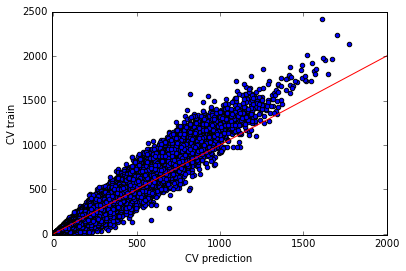

In [28]:
parity_PLOT(Y_hat1,Y_train)

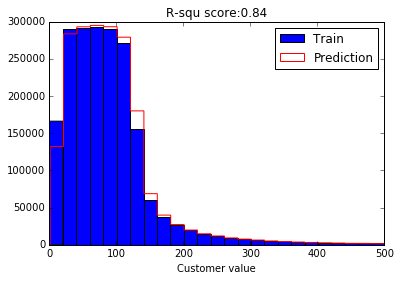

In [47]:
n1,n2,bins1,bins2 = histograms_PLOT(Y_train,Y_hat1,score)

# Dimensionality reduction

The limiting factor on the accuracy of the model is the number of estimators (trees) used in the random forest. Larger values of N return better predictions, but take a lot longer to run. Dimensionality reduction offers a potentail path to removing irrelevant features and reducing the computational run time (allowing for the use of more estimators).

In [15]:
#Check for corralation between features using CHI_squared test.

#if a feature is well coralated with another, it can be removed from the data to reduce run time.
columns = df.columns
tests = {}

for i in columns:
    sample = df[i].values
    for j in columns:
        test = df[j].values
        chi_score, pval = chisquare(sample,test)
        if (chi_score <= 1.*10.**10.) and (chi_score <> 0):
            #print 'Chi score for ',i,':',j,'=',int(round(chi_score,-6))
            text = '{}:{}'.format(i,j)
            tests[text] = int(round(chi_score,-6))
            
#Sort corralations
tests = OrderedDict(sorted(tests.items(), key=lambda x: x[1]))
print tests

#The most corralated propertise are Age and Customer_Value. 
#With a Chi Squared score of 75,000,000 there is 0% probability that these features are corralted. 

OrderedDict([('Age:Customer_Value', 75000000), ('CE_Frozen_Meal_Model:Age', 84000000), ('CE_Pro_Tax_Preparation_Model:Age', 90000000), ('CE_Pet_Model:Age', 91000000), ('CE_Physical_Fitness_Model:Age', 93000000), ('CE_Golf_Model:Age', 93000000), ('CE_Donations_Model:Age', 94000000), ('Gender:Age', 95000000), ('CE_Higher_Education_Model:Age', 97000000), ('CE_Foreign_Travel_Model:Age', 98000000), ('CE_Social_Networking_Model:Age', 102000000), ('CE_Avid_TV_Model:Age', 103000000), ('CE_Frozen_Meal_Model:Customer_Value', 171000000), ('CE_Pro_Tax_Preparation_Model:Customer_Value', 177000000), ('CE_Pet_Model:Customer_Value', 179000000), ('CE_Physical_Fitness_Model:Customer_Value', 180000000), ('CE_Golf_Model:Customer_Value', 180000000), ('CE_Donations_Model:Customer_Value', 181000000), ('Gender:Customer_Value', 182000000), ('CE_Higher_Education_Model:Customer_Value', 184000000), ('CE_Foreign_Travel_Model:Customer_Value', 185000000), ('CE_Social_Networking_Model:Customer_Value', 189000000), ('C

In [19]:
#Feature Selection

# Perform feature selection - calculate ANOVA F-values
selector = SelectKBest(f_classif,k='all')
selector.fit(X_train, Y_train)

# transfrom scores
scores = selector.scores_

# Plot the scores.
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.ylabel('ANOVA F-values')
plt.show()

#Feature selection shows that Age and Income are the most influential predictors. 

KeyboardInterrupt: 

# Reduced Random forest

In [25]:
#Generate attribute and predictors lists
columns = df.columns
attribute_R = columns[0]
predictors_R = columns[2:4]
print predictors_R

Y_train_R = df[attribute_R]
X_train_R = df[predictors_R]
X_test_R = df_test[predictors_R]

Index([u'Age', u'Income'], dtype='object')


In [16]:
#Run Ramdom Forest Model
alg2,Y_hat2 = RF(X_train_R,Y_train_R,50)

#Score Train prediction
score_R = metric.r2_score(Y_train_R.values,Y_hat2)
chi_score_R, pval_R = chisquare(Y_train_R.values, Y_hat2)

print 'R-squ:',round(score_R,3)
print 'Chi-squ:',round(chi_score_R,-6)

R-squ: 0.166
Chi-squ: 158000000.0


In [50]:
n3,n4,bins3,bins4 = histograms_PLOT(Y_train_R,Y_hat2,score_R)

NameError: name 'score_R' is not defined

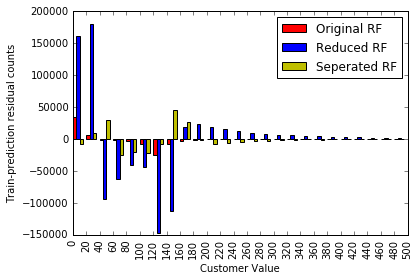

In [94]:
#residual comparison
plt.figure()

#Calculate residuals
res1 = [i-j for i,j in zip(n1, n2)]
res2 = [i-j for i,j in zip(n3, n4)]
res3 = [i-j for i,j in zip(n5, n6)]

#width
w = .25

# Plot the scores.
plt.bar(range(len(bins2))[:-1], res1,w,color='r',label='Original RF')
plt.bar([i+w for i in range(len(bins4))[:-1]], res2,w,color='b',label='Reduced RF')
plt.bar([i+w+w for i in range(len(bins6))[:-1]], res3,w,color='y',label='Seperated RF')
plt.xticks(range(len(bins2)), [int(round(i,-1)) for i in bins2],rotation='vertical')
plt.ylabel('Train-prediction residual counts')
plt.xlabel('Customer Value')
plt.xlim([0,25])
plt.legend()
plt.show()

# Running seperate models

In [107]:
#Generate attribute and predictors feature lists
columns = df.columns
attribute = columns[0]
predictors = columns[1:]

df_lo = df.loc[df['Customer_Value'] < 40 ]
df_md = df.loc[(40 <= df['Customer_Value']) & (df['Customer_Value'] < 160) ]
df_hi = df.loc[df['Customer_Value'] >= 160 ]


#Select data by features
Y_train_lo = df_lo[attribute]
X_train_lo = df_lo[predictors]
Y_train_md = df_md[attribute]
X_train_md = df_md[predictors]
Y_train_hi = df_hi[attribute]
X_train_hi = df_hi[predictors]

Y_train_lo.values

array([ 24.079,  39.295,  23.245, ...,  39.469,  17.656,  29.899])

In [104]:
#Run Ramdom Forest Model
alg_lo,Y_hat_lo = RF(X_train_lo,Y_train_lo,5)
alg_md,Y_hat_md = RF(X_train_md,Y_train_md,50)
alg_hi,Y_hat_hi = RF(X_train_hi,Y_train_hi,50)

df_lo['Predicted_Customer_Value_SRF'] = pd.Series(Y_hat_lo, index=X_train_lo.index)
df_md['Predicted_Customer_Value_SRF'] = pd.Series(Y_hat_md, index=X_train_md.index)
df_hi['Predicted_Customer_Value_SRF'] = pd.Series(Y_hat_hi, index=X_train_hi.index)

df_SRF = pd.concat([df_lo,df_md,df_hi])

#Score Train prediction
print 'score parts'
score_lo = metric.r2_score(Y_train_lo.values,Y_hat_lo)
print 'R-squ:',round(score_lo,3)
score_md = metric.r2_score(Y_train_md.values,Y_hat_md)
print 'R-squ:',round(score_md,3)
score_hi = metric.r2_score(Y_train_hi.values,Y_hat_hi)
print 'R-squ:',round(score_hi,3)
print 'score combined'
score_SRF = metric.r2_score(df_SRF['Customer_Value'].values,
                           df_SRF['Predicted_Customer_Value_SRF'].values)
print 'R-squ:',round(score_SRF,3)
print 'Chi-squ:',round(chi_score,-2)

{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': 'auto', 'max_depth': None}
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': 'auto', 'max_depth': None}


C:\Users\Damian\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Damian\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


score parts
R-squ: 0.908
R-squ: 0.952
R-squ: 0.933
score combined
R-squ: 0.937


In [102]:
df_SRF_5_50_50 = df_SRF 
score parts
R-squ: 0.921
R-squ: 0.952
R-squ: 0.909
score combined
R-squ: 0.967

In [108]:
df_SRF_5_50_50

,Customer_Value,Gender,Age,Income,CE_Pet_Model,CE_Frozen_Meal_Model,CE_Donations_Model,CE_Foreign_Travel_Model,CE_Physical_Fitness_Model,CE_Pro_Tax_Preparation_Model,CE_Golf_Model,CE_Higher_Education_Model,CE_Avid_TV_Model,CE_Social_Networking_Model,Predicted_Customer_Value_SRF
3,24.079,1,25.0,65000.0,-0.331,3.180,-3.364,-3.395,0.401,0.178,1.110,-2.834,0.745,-3.763,24.07900
5,39.295,1,31.0,84000.0,3.744,2.125,2.219,-1.195,4.408,2.407,2.396,0.920,-0.745,4.022,38.54700
21,23.245,1,31.0,36000.0,0.786,-1.228,1.629,-0.604,3.979,-0.796,1.680,1.881,-4.104,-0.180,23.83240
24,13.094,0,19.0,63000.0,-2.830,2.758,6.389,7.095,-6.030,-1.500,-1.187,-1.224,3.305,-1.398,15.29320
27,8.898,1,59.0,15000.0,-1.641,-2.399,0.770,0.915,-0.088,0.977,0.774,-1.355,3.435,2.245,8.90380
30,26.654,0,30.0,64000.0,1.717,9.600,2.566,2.530,-0.760,-0.568,6.756,-4.447,2.121,-4.235,27.37160
31,18.235,0,21.0,108000.0,4.845,13.682,0.796,0.658,0.998,0.543,5.825,-0.539,-3.535,-9.325,16.64540
32,28.184,0,31.0,59000.0,-0.731,2.624,-0.636,-1.823,0.648,3.912,-2.215,4.978,-5.928,-4.297,32.06480
38,17.696,0,25.0,63000.0,1.882,-3.806,2.754,3.095,2.467,0.315,2.197,2.198,-7.968,-1.439,17.69600
39,38.510,1,33.0,74000.0,-0.490,0.939,0.614,1.837,-0.050,2.554,0.919,-1.073,-2.399,-5.454,38.28360


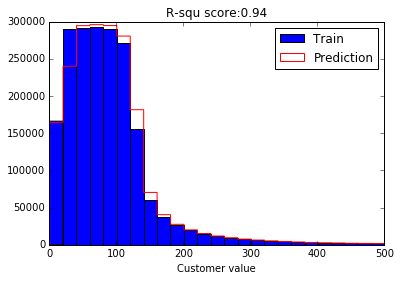

In [105]:
n5,n6,bins5,bins6 = histograms_PLOT(df_SRF['Customer_Value'],
                              df_SRF['Predicted_Customer_Value_SRF'],
                              score_SRF)

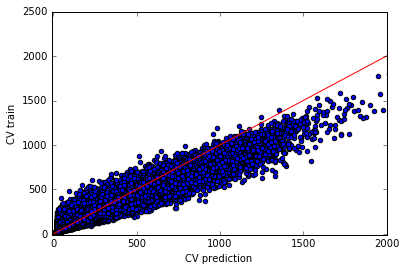

In [106]:
parity_PLOT(df_SRF['Customer_Value'],
            df_SRF['Predicted_Customer_Value_SRF'])

In [21]:
#Save predictions as CSV
df['Predicted_Customer_Value_ORF'] = pd.Series(Y_hat1, index=df.index)
df['Predicted_Customer_Value_RRF'] = pd.Series(Y_hat2, index=df.index)
#df['Predicted_Customer_Value_SRF'] = pd.Series(df_SRF_5_50_50['Predicted_Customer_Value_SRF'], index=df.index)

df.to_csv('modellingProjectTraining_predictions.txt', sep=';')

Conclusions on models:

- At this point the largest random forest I have been able to run on the original data is 50 estimators/trees. The metrics for this model is R-squ: 0.944.
- Increasing the number of estimators improves the metrics but a) takes longer to complete and b) risks over-fitting to the train data.
- Feature selection identifys that Age and Income are the most influential predictors for the customer value. CF attributes are roughly similar in influence. None of the features are corralated to each other.
- Reducing the data to just Age and Income reduces the run time of the random forrest but is significantly detrimental to metrics, with N=50 scoring R-squ: 0.166.
- Both RF models significantly under-predict the lowest customer values (up to 40). They slightly over-predict customer values between 40 and 160. The orignal data is very accurate for customer values over 160, whereas the reduced model slightly over predicts these values. I could attempt to model each of these three clusters seperately?

2) Use your model to predict the ‘Consumer Value’ of the 500,000 targets provided in the file “modellingProjectModelling.txt”. Try to determine how effective you expect your model to be at predicting values for out-of-sample data.

In [22]:
#Predict attribute 'Customer Value' 
X_test = df_test[predictors]
Y_hat_test = alg1.predict(X_test)

In [24]:
#Add the prediction to the test data
df_test['Predicted_Customer_Value'] = pd.Series(Y_hat_test, index=df_test.index)
df_test.head()

,Customer_ID,Gender,Age,Income,CE_Pet_Model,CE_Frozen_Meal_Model,CE_Donations_Model,CE_Foreign_Travel_Model,CE_Physical_Fitness_Model,CE_Pro_Tax_Preparation_Model,CE_Golf_Model,CE_Higher_Education_Model,CE_Avid_TV_Model,CE_Social_Networking_Model,Predicted_Customer_Value
0,2000000,1,70.0,37000.0,-0.948,-4.654,2.314,-0.962,3.077,1.218,2.613,1.190,-4.215,-0.534,52.44016
1,2000001,0,27.0,135000.0,2.128,12.758,0.856,-1.899,1.155,1.797,6.129,-0.819,-0.123,1.606,34.86222
2,2000002,1,31.0,88000.0,1.737,-0.312,-1.340,-6.317,4.857,4.189,0.897,2.467,-2.471,1.151,62.48966
3,2000003,1,44.0,128000.0,3.180,-3.670,1.393,0.655,2.211,3.477,-5.705,4.287,-1.470,5.401,131.26288
4,2000004,0,48.0,135000.0,1.929,8.700,1.614,-0.443,-2.909,1.752,1.016,0.408,-2.552,-6.224,106.97620


3) Finally, conduct some initial market analysis for the company of their customer base involving some visualization procedure for the data that can be presented alongside your results to help them better understand their customer base.

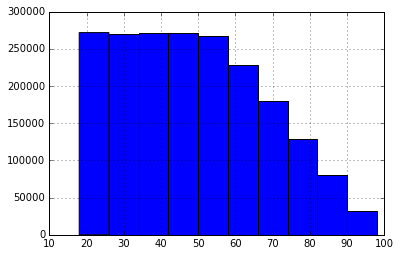

In [25]:
#Visualise data via histograms
df.Age.hist(bins=10)

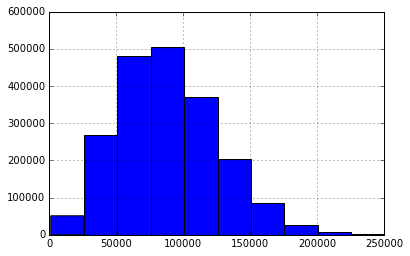

In [26]:
#Visualise data via histograms
df.Income.hist(bins=10)

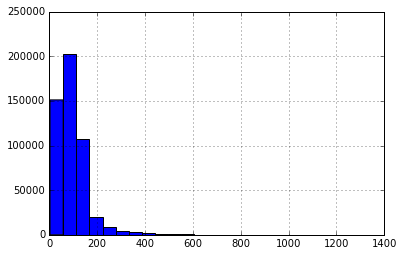

In [27]:
df_test.Predicted_Customer_Value.hist(bins=25)
#df.Customer_Value.hist(bins=25)

Your predicted scores should be provided as a semi-colon delimited text file containing a Costomer_ID and a Predicted_Customer_Value on each. Your market analysis may be in any soft or hard format that you prefer.

In [42]:
#Save results as deliverable

df_deliver = pd.DataFrame({'Customer_ID':df_test['Customer_ID'],
                           'Predicted_Customer_Value':df_test['Predicted_Customer_Value']})
df_deliver.to_csv('modellingProjectModelling_predictions.txt', sep=';')
df_deliver.head()

,Customer_ID,Predicted_Customer_Value
0,2000000,52.44016
1,2000001,34.86222
2,2000002,62.48966
3,2000003,131.26288
4,2000004,106.97620


ARCHIVED

In [ ]:
#Random Forrest via Classifier - NOT WORKING
alg2 = RandomForestClassifier(n_estimators=N)
alg2.fit(X_train.as_matrix(), Y_train.as_matrix())
Y_hat2 = alg2.predict(Y_test)

In [ ]:
#Random Forrest via K-fold classifer - NOT WORKING
#Calculate the K fold cross validation
kf = KFold(X_train.shape[0], n_folds=4, random_state=1)
alg3 = RandomForestClassifier(n_estimators=10)
#Y_hat3 = alg3.predict(Y_test)
scores = cross_validation.cross_val_score(alg3, X_train, Y_train, cv=kf)
print scores.mean()